In [7]:
#importing libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy as stats 

In [8]:
#load file with data
#path to access file 
file_path = "NOVA_flux_nue"
#name the columns 
columns = ["emin","emax","nus","fe"]
#read the data 
data = pd.read_csv(file_path,delim_whitespace=True,skiprows=5,names=columns)
print(data)

#bins so we need the midpoint 
data['E_mid'] = (data['emin']+data['emax'])/2

    emin  emax     nus     fe
0    0.0   0.5  0.0707  0.118
1    0.5   1.0  0.1502  0.112
2    1.0   1.5  0.1783  0.093
3    1.5   2.0  0.1635  0.105
4    2.0   2.5  0.1387  0.097
5    2.5   3.0  0.1076  0.096
6    3.0   3.5  0.0827  0.081
7    3.5   4.0  0.0655  0.088
8    4.0   4.5  0.0576  0.096
9    4.5   5.0  0.0513  0.095
10   5.0   6.0  0.0943  0.094
11   6.0   7.0  0.0853  0.099
12   7.0   8.0  0.0750  0.089
13   8.0   9.0  0.0653  0.104
14   9.0  10.0  0.0524  0.103
15  10.0  12.0  0.0710  0.105
16  12.0  14.0  0.0393  0.137
17  14.0  16.0  0.0235  0.159
18  16.0  18.0  0.0143  0.185
19  18.0  20.0  0.0087  0.262


In [9]:
#programming a function for PMNS matrix 

def pmns_matrix(t_12,t_13,t_23,d_cp):

#t_12 - mixing angle in radian between v1 and v2 
#t_13 - mixing angle in radian between v1 and v3
#t_23 - mixing angle in radian between v2 and v3 
#d_cp - complex phase that introduces a difference between neutrino and antineutrino 

    s_12 = np.sin(t_12)
    s_13 = np.sin(t_13)
    s_23 = np.sin(t_23)
    c_12 = np.cos(t_12)
    c_13 = np.cos(t_13)
    c_23 = np.cos(t_23)
    
    #formula for U aka PMNS matrix is on wikipedia 
    U = np.array([[c_12*c_13,s_12*c_13,s_13*np.exp(-1j*d_cp)],[-(s_12*c_23)-(c_12*s_23*s_13*np.exp(1j*d_cp)),(c_12*c_23)-(s_12*s_23*s_13*np.exp(1j*d_cp)),s_23*c_13],[(s_12*s_23)-(c_12*c_23*s_13*np.exp(1j*d_cp)),-(c_12*s_23)-(s_12*c_23*s_13*np.exp(1j*d_cp)),c_23*c_13]])
    return U #returns a 3x3 matrix

In [10]:
#programming a function for osclation probability

#U - PMNS matrix
#d_m2 - list of mass squared difference of neutrino eigenstate 
#L - distance neytrino travells from source to detector 
#E - neutrino energy 
#alpha - initial neutrino flavour 
#beta - final neutrino flavour 

def oscillation_probability(U,d_m2,L,E,alpha,beta):
   
    #oscilation phase
    oscilation_phase = [1.27 * d_m * L/E for d_m in d_m2]
    
    #compute probsability by looping over mass eigenstate 
    prob = 0 #initialize probabilty 
    for i in range(3): #loop over list in d_m3
        for j in range(3):
            if i != j:
                phase = np.exp(-1j * oscilation_phase[i-j]) #oscilation phase
            else:
                phase = 1
           #add to probability 
            prob += (U[alpha,i].conj()*U[beta,i]*U[alpha,j]*U[beta,j].conj()*phase)
    return np.abs(prob)**2                             
    



In [11]:
#parameters 
L = 810
d_m2 = [7.42e-5,2.517e-3,2.517e-3 + 7.42e-5]
t_12=np.radians(33.44)
t_13=np.radians(8.57)
t_23=np.radians(49.2)
d_cp=np.radians(222)

#compute MAtrix 
U = pmns_matrix(t_12,t_13,t_23,d_cp)


In [12]:
# Calculate probability - electron to muon 
data['P_nue_to_numu'] = data['E_mid'].apply(lambda E: oscillation_probability(U, d_m2, L, E, alpha=0, beta=1))

# Compute oscillated flux - electron to muon 
data['oscillated_flux'] = data['nus'] * data['P_nue_to_numu']  

# Calculate probability - electron to tau 
data['P_nue_to_nuta'] = data['E_mid'].apply(lambda E: oscillation_probability(U, d_m2, L, E, alpha=0, beta=2))

# Compute oscillated flux - electron to tau 
data['oscillated_flux_2'] = data['nus'] * data['P_nue_to_nuta']  

# Calculate probability - muon to tau 
data['P_numu_to_nuta'] = data['E_mid'].apply(lambda E: oscillation_probability(U, d_m2, L, E, alpha=1, beta=2))

# Compute oscillated flux - muon to tau 
data['oscillated_flux_3'] = data['nus'] * data['P_numu_to_nuta']  

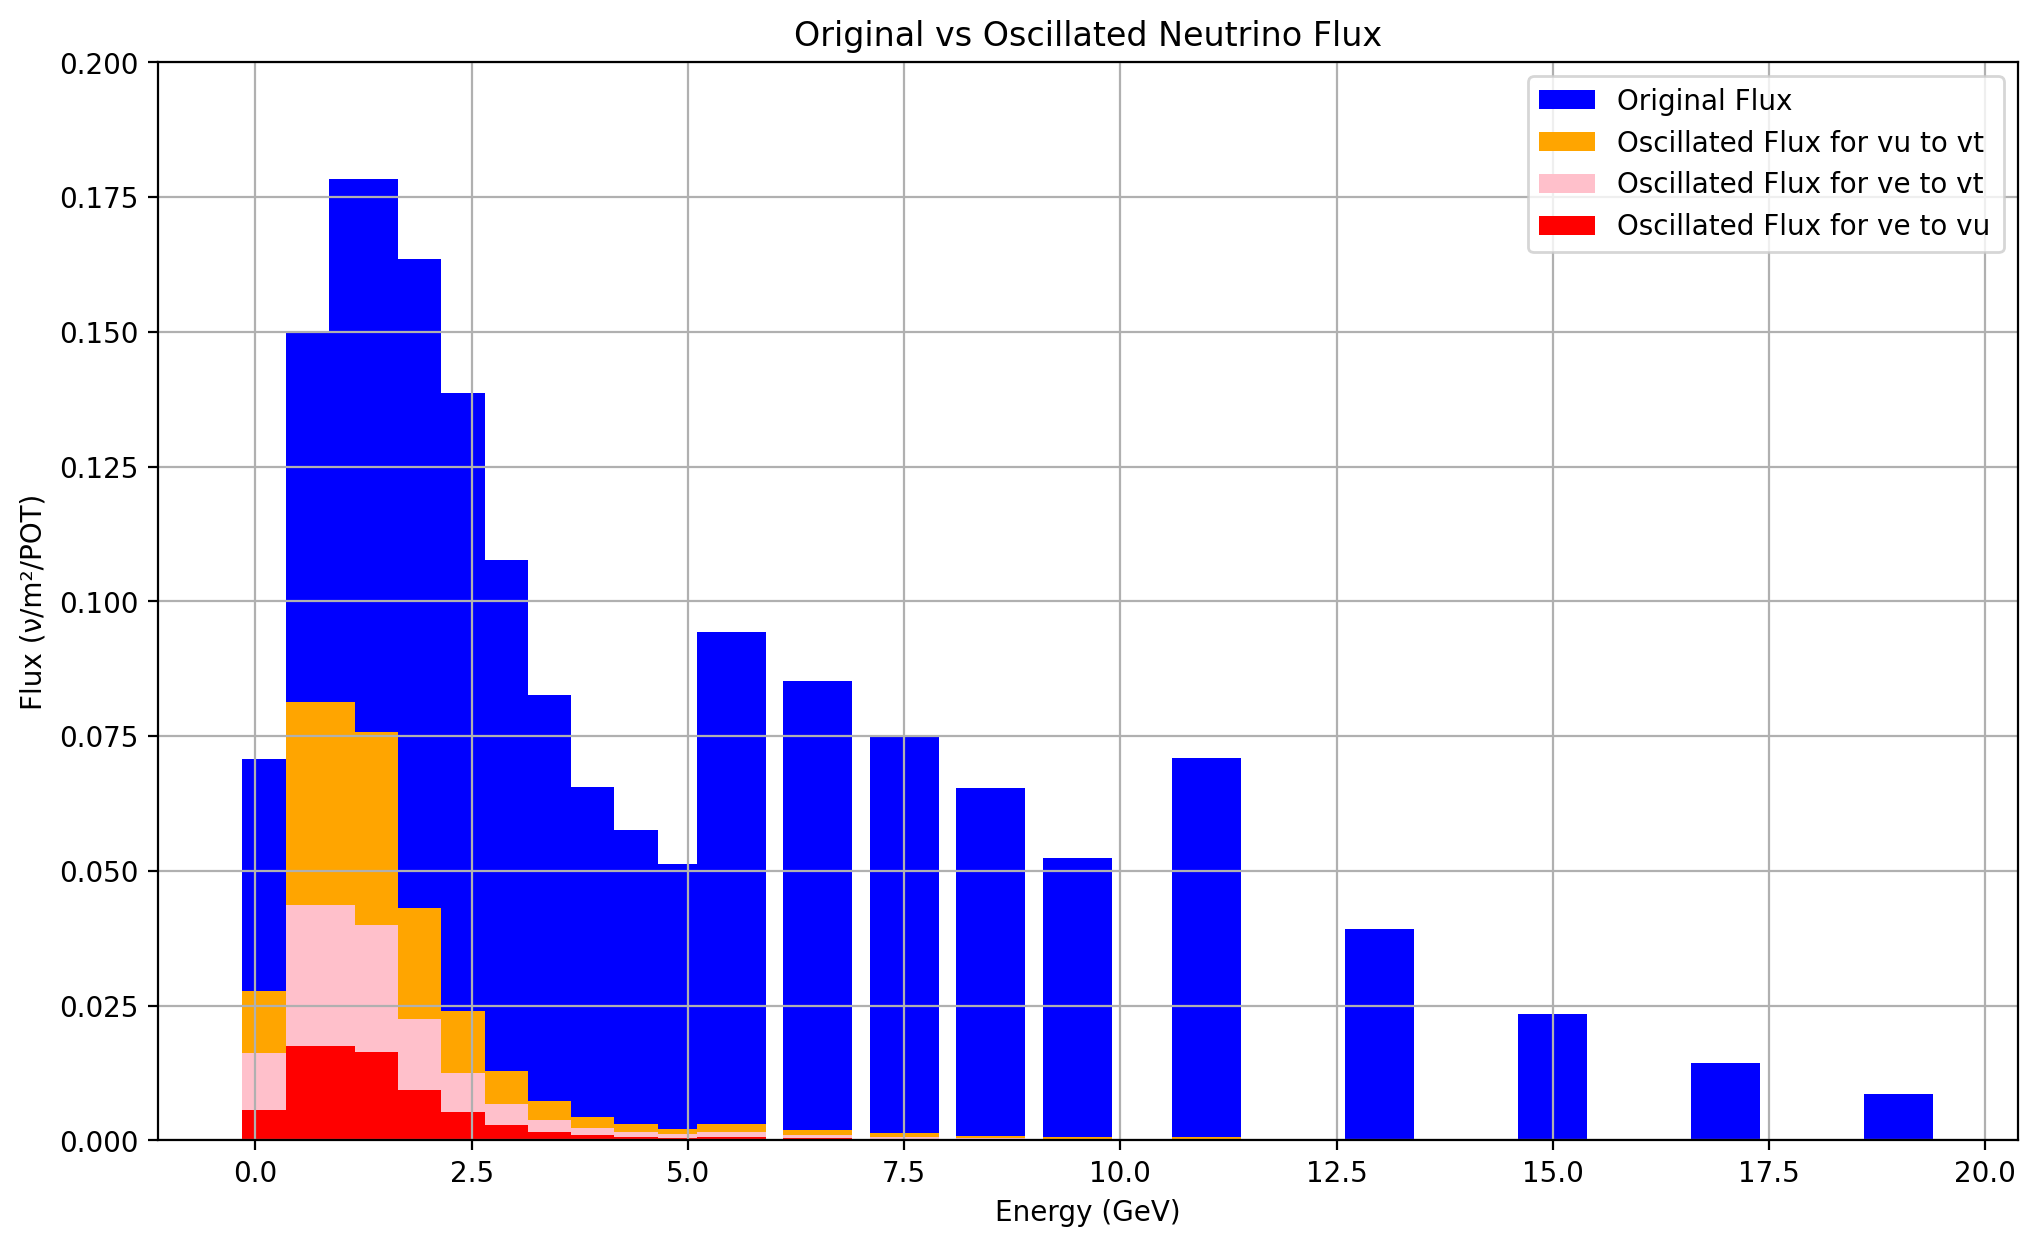

In [17]:
# Plot the original and oscillated flux
plt.figure()
plt.bar(data['E_mid'], data['nus'],label="Original Flux",color = 'blue')
plt.bar(data['E_mid'], data['oscillated_flux_3'],label="Oscillated Flux for vu to vt ",color='orange')
plt.bar(data['E_mid'], data['oscillated_flux_2'],label="Oscillated Flux for ve to vt",color='pink')
plt.bar(data['E_mid'], data['oscillated_flux'],label="Oscillated Flux for ve to vu",color='red')
plt.xlabel("Energy (GeV)")
plt.ylabel("Flux (ν/m²/POT)")
plt.legend()
plt.title("Original vs Oscillated Neutrino Flux")
plt.ylim(0, 0.2)  # Zoom in on y-axis

plt.grid()
plt.show()


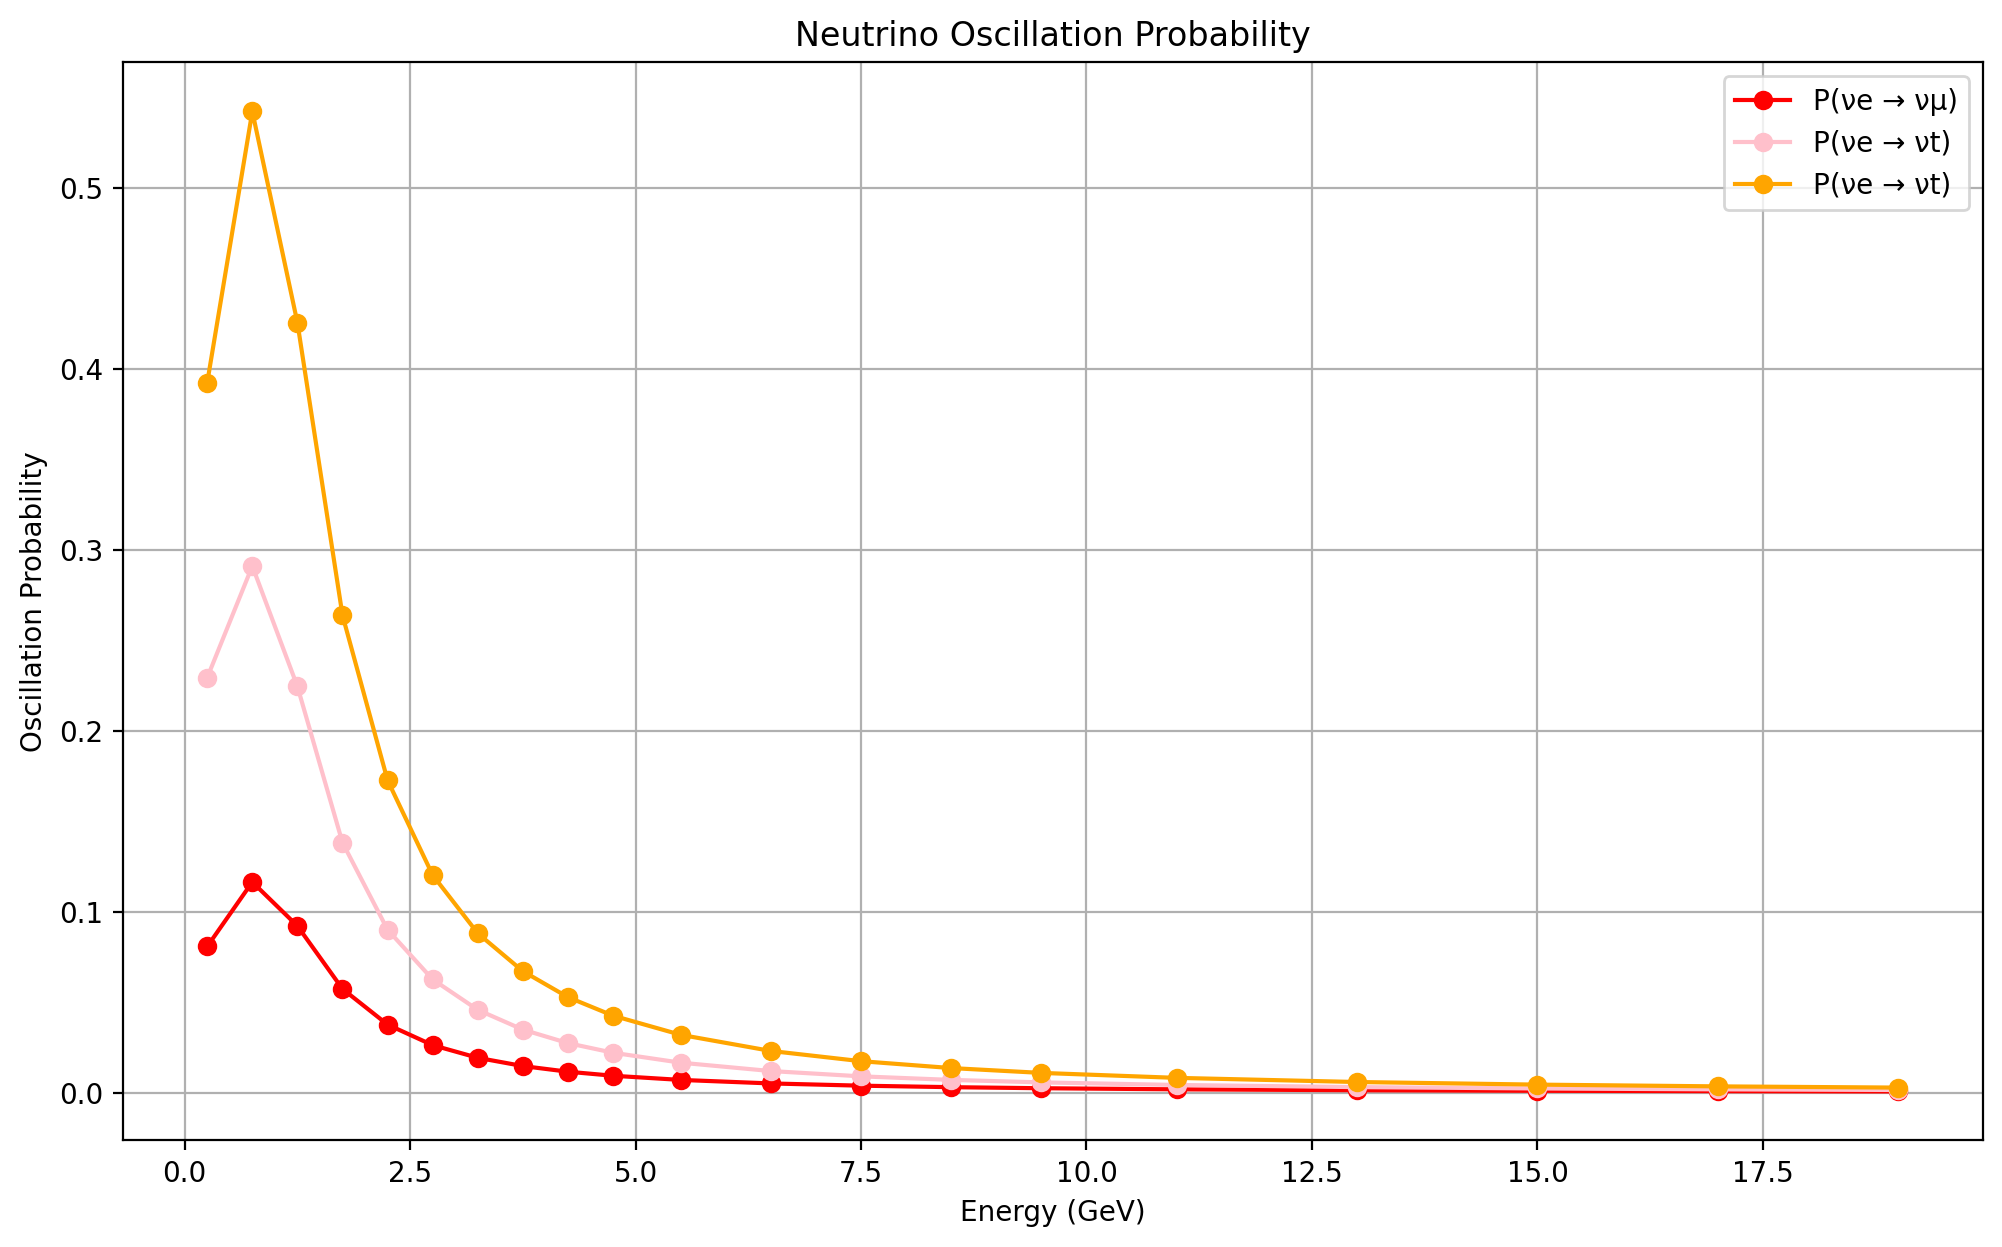

In [14]:
#plot oscilation probavility 
plt.figure()
plt.plot(data['E_mid'], data['P_nue_to_numu'], marker='o', label="P(νe → νμ)", color='red')
plt.plot(data['E_mid'], data['P_nue_to_nuta'], marker='o', label="P(νe → νt)", color='pink')
plt.plot(data['E_mid'], data['P_numu_to_nuta'], marker='o', label="P(νe → νt)", color='orange')
plt.xlabel("Energy (GeV)")
plt.ylabel("Oscillation Probability")
plt.title("Neutrino Oscillation Probability")
plt.legend()
plt.grid()
plt.show()

In [15]:
print(data[['E_mid', 'P_nue_to_numu']])

    E_mid  P_nue_to_numu
0    0.25       0.080685
1    0.75       0.116300
2    1.25       0.092029
3    1.75       0.057244
4    2.25       0.037526
5    2.75       0.026164
6    3.25       0.019179
7    3.75       0.014621
8    4.25       0.011498
9    4.75       0.009271
10   5.50       0.006966
11   6.50       0.005018
12   7.50       0.003785
13   8.50       0.002954
14   9.50       0.002370
15  11.00       0.001771
16  13.00       0.001270
17  15.00       0.000955
18  17.00       0.000744
19  19.00       0.000596


SyntaxError: invalid syntax (807159755.py, line 2)

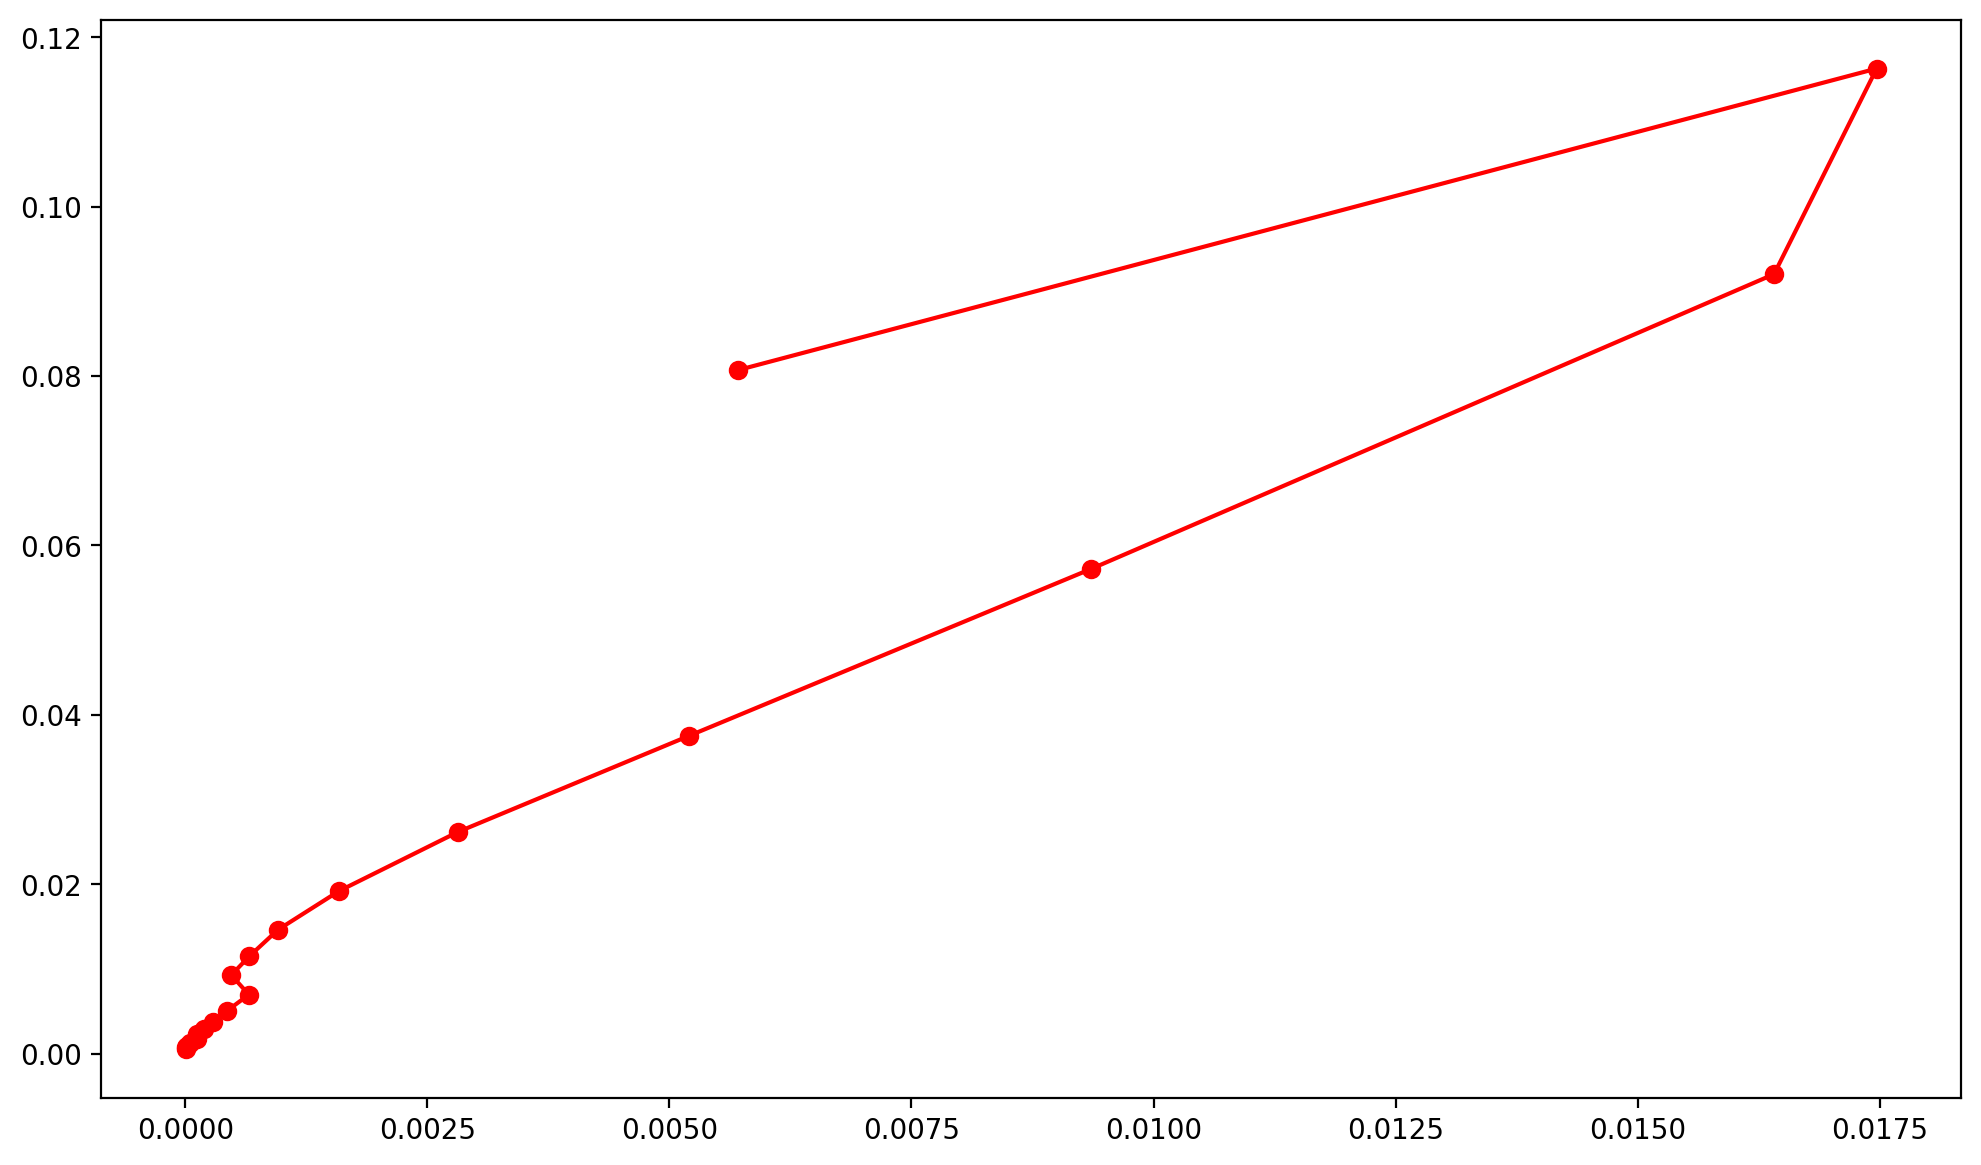

In [21]:
plt.figure()
plt.plot(data['P_nue_to_numu'],data['oscillated_flux'] marker='o', label="P(νe → νμ)", color='red')